In [1]:
import json
import requests

from tqdm import tqdm
from pprint import pprint
from collections import defaultdict
from hashlib import md5

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from datetime import datetime
def to_dt(ts: int): return datetime.fromtimestamp(ts // 1000)

## Checking hashes

In [26]:
import requests
import json

requests.packages.urllib3.disable_warnings() 

url = 'https://stat.vybory.gov.ru/api/blocks/search'
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}

new_blocks = json.loads(requests.post(url, json=json.loads('{"shard": null, "height": 58}'), headers=headers, verify=False).text)['data']['results']
pprint(new_blocks)

[{'eventType': 'BLOCK_APPENDED',
  'height': 58,
  'id': '8bcdc0d3-de97-4f4c-8662-6eb90a2c772d',
  'minerAddress': '3EMnYeT17oir1peq1doZr3V5RkDwyAneDRx',
  'reference': '2MU4sCKC6tsSDrXfVS41fzjUfsFiby5oRwsYxJXLptSRMkVEnSwuYrQCNEJbhMPusfvp1uHPLhV7ybgFUKgZDkbM',
  'shard': 'blockchain-shard-0',
  'signature': 'xKf67wgUUPvUupMiU96Yhe1ftZzZ1xDiC8k2aW925Sb2Y393DtQ2ayShAyDJjjs9KB9xCHWSk1ZPGc8TuCK3Mvf',
  'timestamp': '05 сентября, 21:46:49 мск',
  'transactionsCount': 0}]


In [31]:
import base58
base58.b58encode(b'hello world')

b'StV1DL6CwTryKyV'

In [27]:
with open('edg2024.json', 'r') as file:
    for line in file:
        block = json.loads(line)
        if block['reference'] == '2MU4sCKC6tsSDrXfVS41fzjUfsFiby5oRwsYxJXLptSRMkVEnSwuYrQCNEJbhMPusfvp1uHPLhV7ybgFUKgZDkbM':
            pprint(block)
            break

{'blocksize': 878,
 'cft-consensus': {'overall-skipped-rounds': 4322854,
                   'votes': [{'blockVotingHash': 'GupPzLBA3L3vCpC9d9jmDdxnEsPNArED8D8qPP8wRURj',
                              'sender': '3EUstFhyAUen7vyrsuxLxFXT2yEWWyqfJnb',
                              'signature': '34XPKeC5Ph6MCvZX5bknko3WSeFayx8kZCyvBG87LzvVR91QFvDwhx9AerZZiqSjqMfido48MLmwCjVgN97PHCdx'},
                             {'blockVotingHash': 'GupPzLBA3L3vCpC9d9jmDdxnEsPNArED8D8qPP8wRURj',
                              'sender': '3EKgAd9s72N8Vr4BwkBnyT7MexMQQttcgUS',
                              'signature': '31A3RgdjcfL4zAW3fxrNEtJ5FWQA2Ei6xkJMGh8brPLwcFo7pxAZAFFjhG8A6LAacV4dN4aTRXz9Zw3uHeAdsa2g'},
                             {'blockVotingHash': 'GupPzLBA3L3vCpC9d9jmDdxnEsPNArED8D8qPP8wRURj',
                              'sender': '3EXGuTgVx7BgCccaLC3sVsjGXpnVrJgwtXz',
                              'signature': '5ci5qgnZbuthNs5B1kq89uTVwuLNybfndZ3LNsYMWNCQEaGwJrUfwHoQ82WjqQwN2rgrF9Ee9SLAVYrUK8r

## Map visualization

In [ ]:
# map
# vote chart
# select specific region
# hashes and times

In [45]:
%%javascript
element.text('hello world');

<IPython.core.display.Javascript object>

## Continuity check

In [2]:
def get_hashes(fname: str) -> str:
    """Calculates a set of md5 hashes for every block"""
    hashes = set()
    with open(fname, 'r') as file:
        for line in tqdm(file):
            hashes.add(md5(line.encode('utf-8')).hexdigest())
    return hashes

In [8]:
d1 = get_hashes('dumps/control/dump_day1.json')
d2 = get_hashes('dumps/control/dump_day2.json')
d1 <= d2  # check if d1 is a subset of d2

28016it [00:08, 3349.76it/s] 
62520it [00:14, 4274.31it/s] 


True

## Parsing metadata via API

In [80]:
def load(endpoint):
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    raw_data = requests.get(f'https://stat.vybory.gov.ru/api/{endpoint}', headers=headers, verify=False).text
    return json.loads(raw_data)['data']

requests.packages.urllib3.disable_warnings() 

In [81]:
map_contracts = {}  # id -> (region_code, region_name, election, district)
map_regions = {}  # region_code -> (region_name, region_description)
for region in load('voting/regions')['regions']:
    map_regions[region['code']] = (region['name'], region['description'])

    #elections = {}
    for level in load(f'elections/region/{region['code']}/elections')['elections']:
        for election in level['elections']:
            #elections[election['electionId']] = election['electionName']

            #districts = {}
            for district in load(f'elections/districts?regionCode={region['code']}&electionId={election['electionId']}'):
                #districts[district['id']] = district['name']
                data = load(f'statistics/voting?electionId={election['electionId']}&districtId={district['id']}')
                for voting in data['votings']:
                    map_contracts[voting['counters']['contractId']] = (data['regionCode'], data['regionName'], data['electionName'], data['districtName'])
                    pprint(map_contracts[voting['counters']['contractId']])

(2,
 'ALTAI_REPUBLIC',
 'Дополнительные выборы  депутатов Совета депутатов Ябоганского сельского '
 'поселения',
 'Второй')
(2,
 'ALTAI_REPUBLIC',
 'Выборы Главы Узнезинского сельского поселения Чемальского района Республики '
 'Алтай',
 'Чемальская районная территориальная избирательная комиссия')
(2,
 'ALTAI_REPUBLIC',
 'Выборы Главы Паспаульского сельского поселения Чойского района Республики '
 'Алтай ',
 'Чойская районная территориальная избирательная комиссия')
(2,
 'ALTAI_REPUBLIC',
 'Выборы главы Онгудайского сельского поселения Онгудайского района Республики '
 'Алтай',
 'Онгудайская районная территориальная избирательная комиссия')
(2,
 'ALTAI_REPUBLIC',
 'Выборы Главы Соузгинского сельского поселения',
 'Майминская районная территориальная избирательная комиссия')
(2,
 'ALTAI_REPUBLIC',
 'Выборы Главы  Турочакского сельского поселения Турочакского района '
 'Республики Алтай',
 'Турочакская районная территориальная избирательная комиссия')
(2,
 'ALTAI_REPUBLIC',
 'Повторные 

In [82]:
import pickle

with open('maps.pkl', 'wb') as file:
    pickle.dump((map_regions, map_contracts), file)

In [2]:
import pickle

with open('../maps.pkl', 'rb') as file:
    map_regions, map_contracts = pickle.load(file)

## Parsing transactions

In [84]:
blocks = []

elections = {}  # contractId -> pollId
voter_lists = defaultdict(list)

raw_transactions = {}

all_hashes = set()
removed_hashes = set()
signature_hashes = set()

results = {}

signatures = defaultdict(list)
votes = defaultdict(list)

optypes = set()

with open('edg2024.json', 'r') as file:
    for line in file:
        block = json.loads(line)
        blocks.append((block['timestamp'], block['transactionCount']))
        for transaction in block['transactions']:
            if transaction['type'] == 105 and transaction['tx']['type'] == 104:
                ts = transaction['tx']['timestamp']
                contract_id = transaction['tx']['contractId']
                params = {p['key']: p['value'] for p in transaction['tx']['params']}

                optype = params['operation']
                optypes.add(optype)
                
                if optype == 'addVotersList' or optype == 'removeFromVotersList' or optype == 'addToVotersList':
                    #region = int(params['primaryUikRegionCode'])
                    uik = params['primaryUikNumber']
                    hashes = json.loads(params['userIdHashes'])

                    voter_lists[(contract_id, uik)].append((optype, len(hashes)))
                    # check hashes?
                elif optype == 'startVoting':
                    poll_id = json.loads(transaction['results'][0]['value'])['pollId']
                    assert(contract_id not in elections)
                    elections[contract_id] = poll_id
                elif optype == 'blindSigIssue':
                    region = int(params['primaryUikRegionCode'])
                    uik = params['primaryUikNumber']
                    signatures[contract_id].append((region, uik, to_dt(ts)))
                    signature_hash = json.loads(params['data'])[0]['userId']
                    signature_hashes.add(signature_hash)
                elif optype == 'vote':
                    transaction_id = transaction['tx']['id']
                    raw_transactions[transaction_id] = transaction['tx']
                    votes[contract_id].append(to_dt(ts))
                elif optype == 'results':
                    results[transaction['tx']['contractId']] = json.loads(params['results'])[0]

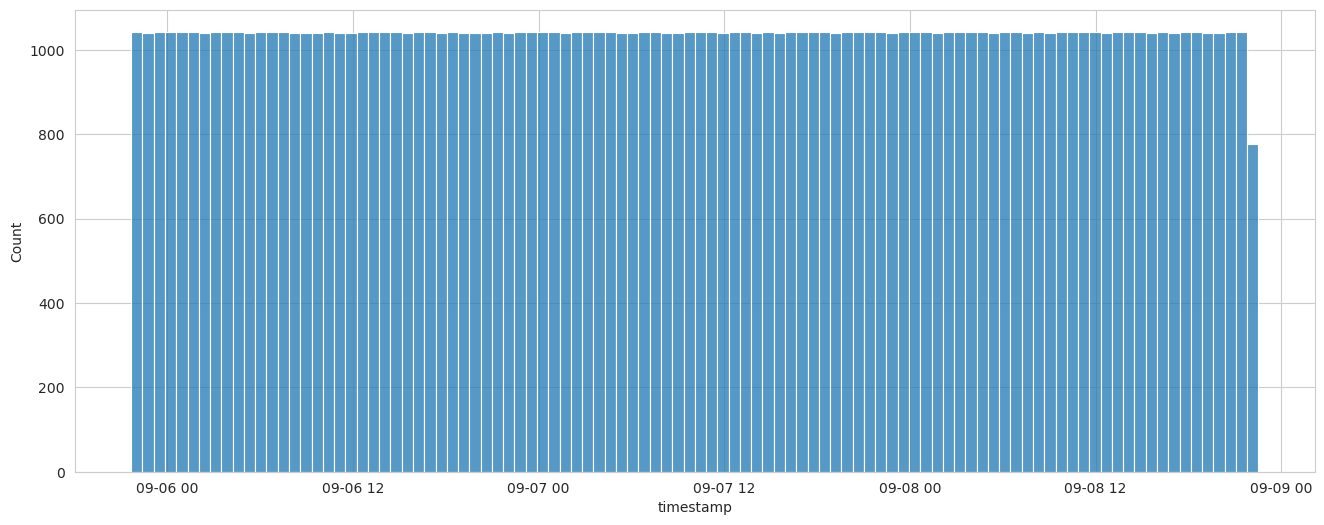

In [85]:
data = [(to_dt(ts), count) for ts, count in blocks]
df = pd.DataFrame(data, columns=['timestamp', 'transaction_count'])

plt.figure(figsize=(16, 6))
sns.histplot(df[df.timestamp > datetime(2024, 9, 5)].timestamp, bins=100)
plt.show()

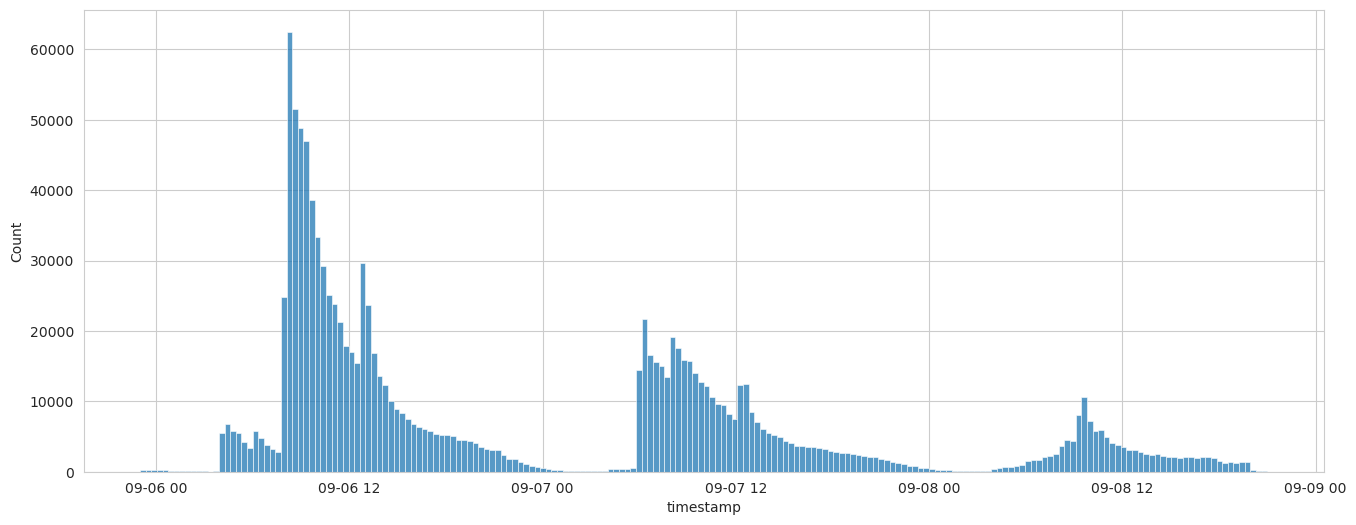

In [86]:
data = []

for contract_id, l in signatures.items():
    for region, uik, ts in l:
        data.append((contract_id, region, uik, ts))

df = pd.DataFrame(data, columns=['election', 'region', 'uik', 'timestamp'])


plt.figure(figsize=(16, 6))

#sns.histplot(df[(df.region == 2) & (df.timestamp < datetime(2024, 9, 6, 4, 10))].timestamp, bins=200)
#sns.histplot(df[(df.region == 50) & (df.timestamp < datetime(2024, 9, 6, 8, 10))].timestamp, bins=200)
#sns.histplot(df[(df.timestamp > datetime(2024, 9, 7, 12)) & (df.timestamp < datetime(2024, 9, 7, 14))].timestamp, bins=200)
sns.histplot(df.timestamp[df.timestamp > datetime(2024, 9, 5)], bins=200)

plt.show()
#plt.savefig('turnout.png')

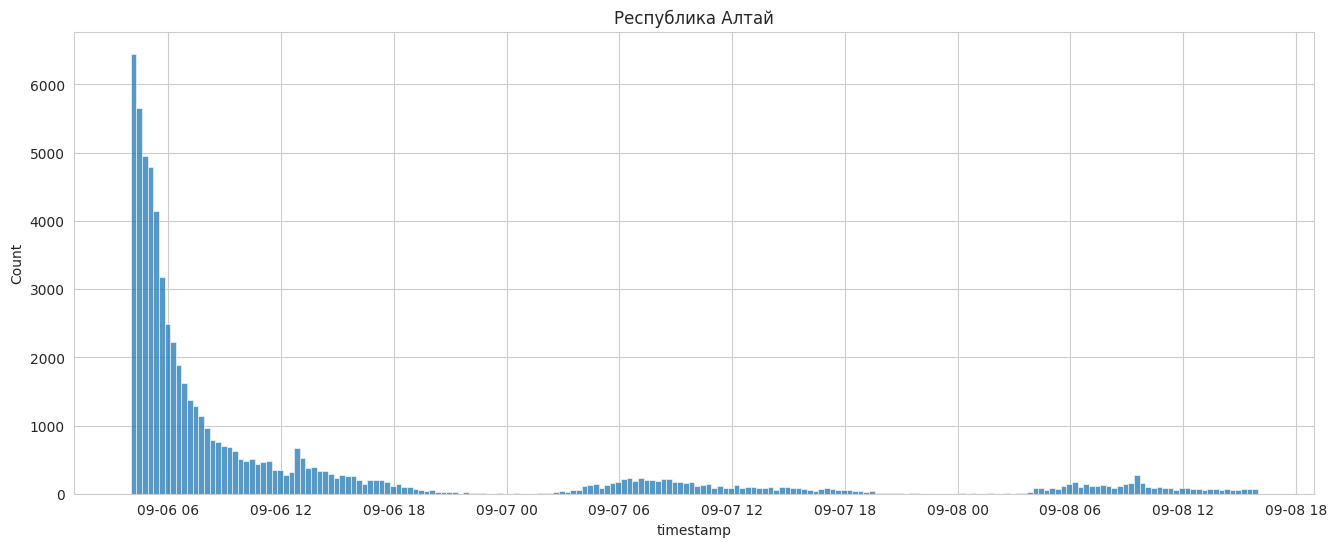

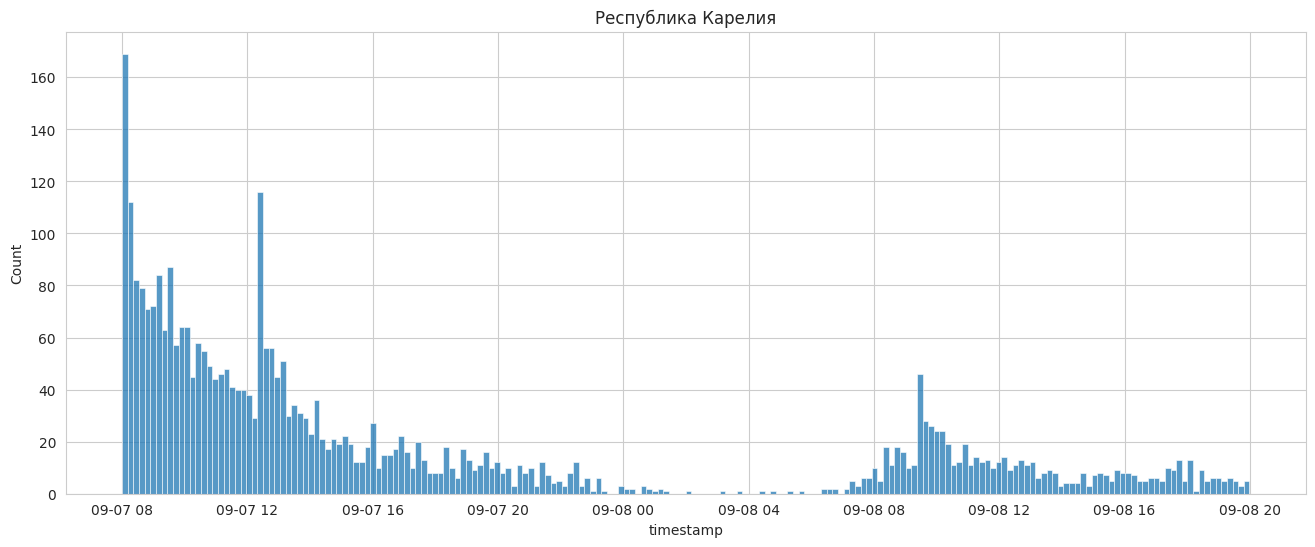

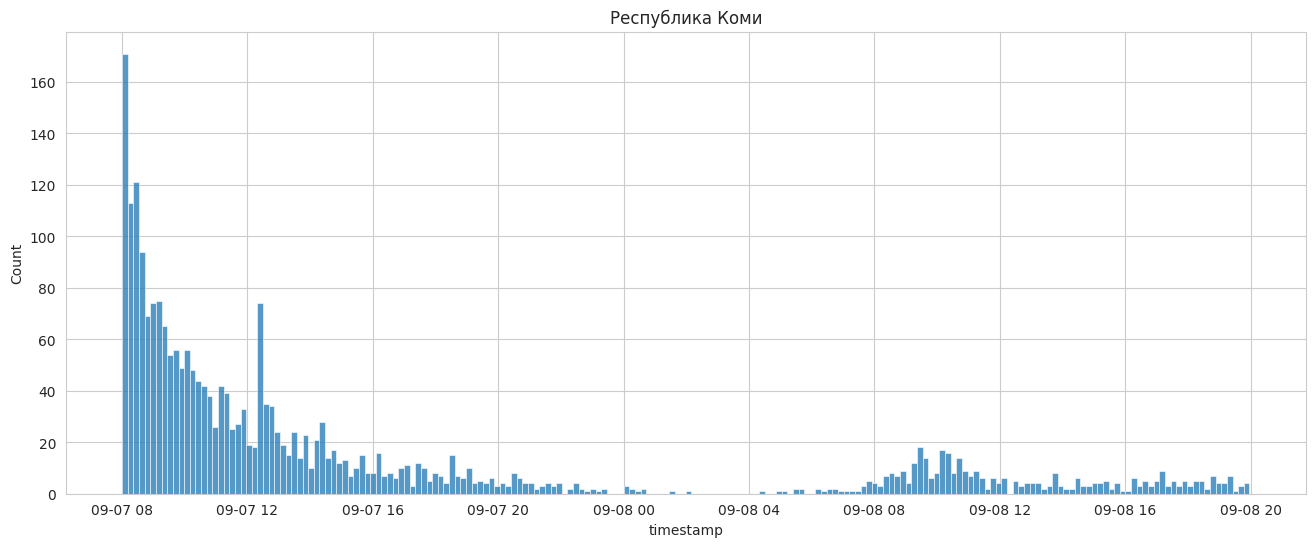

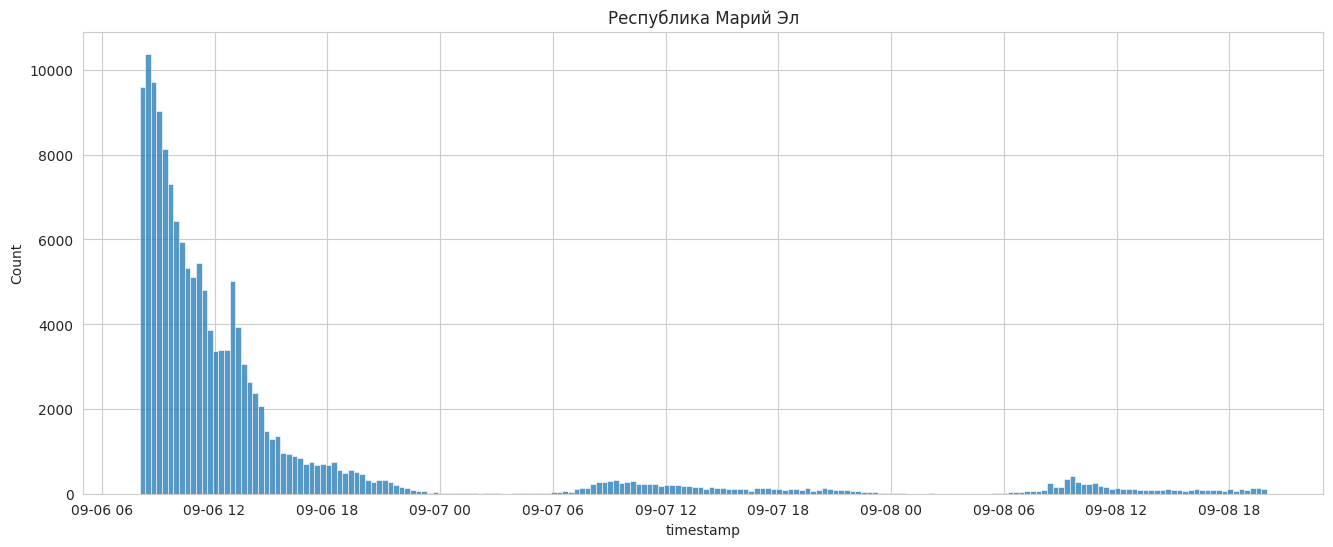

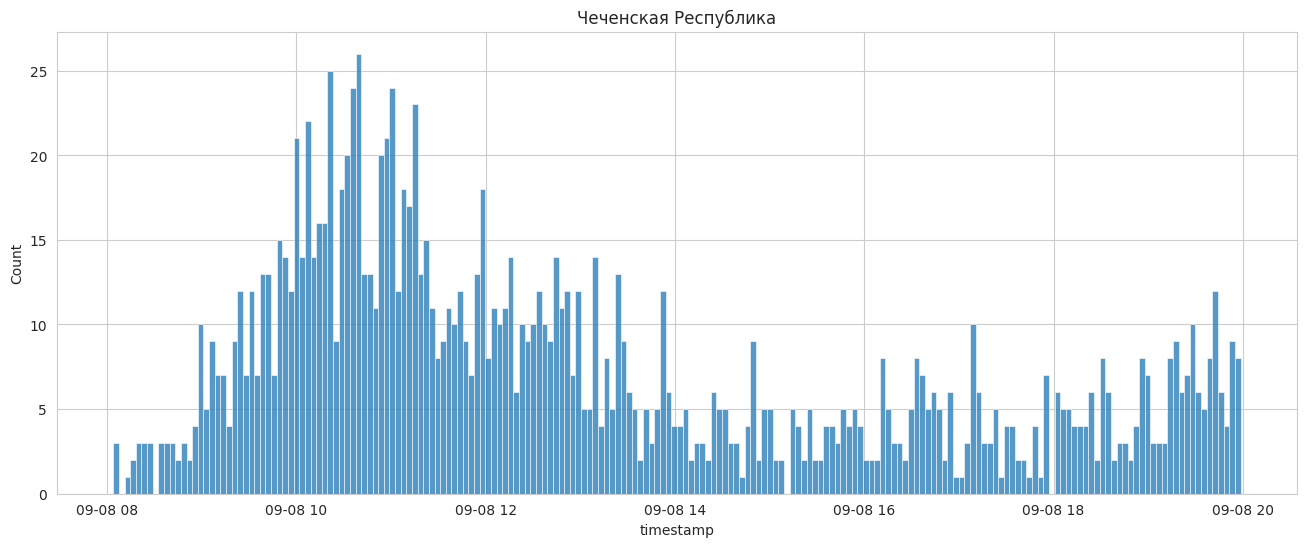

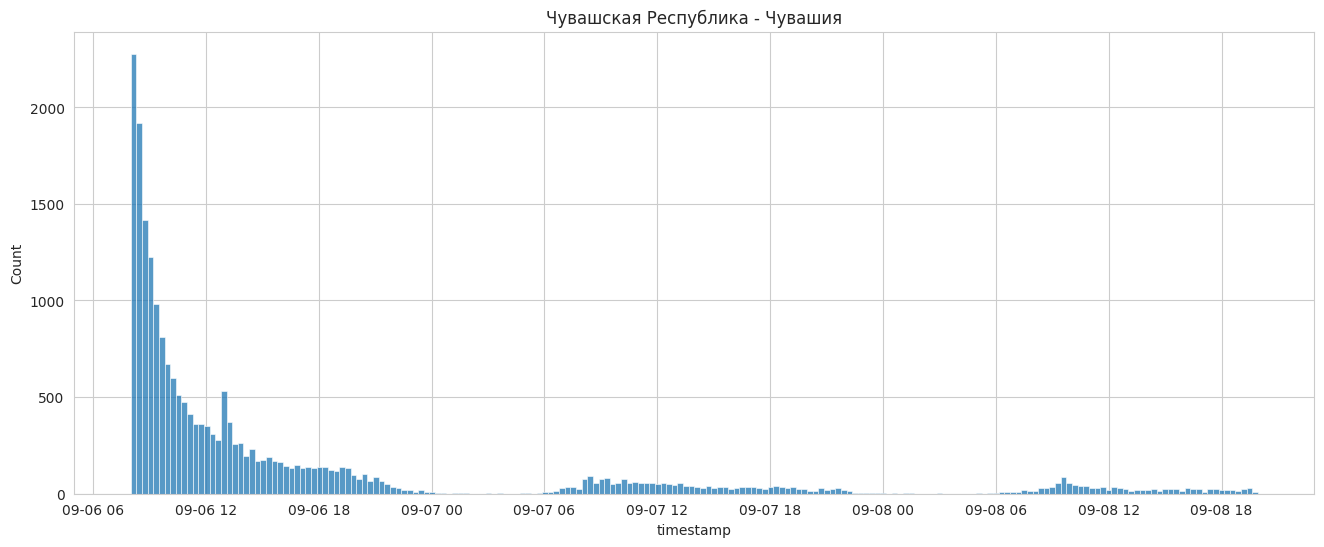

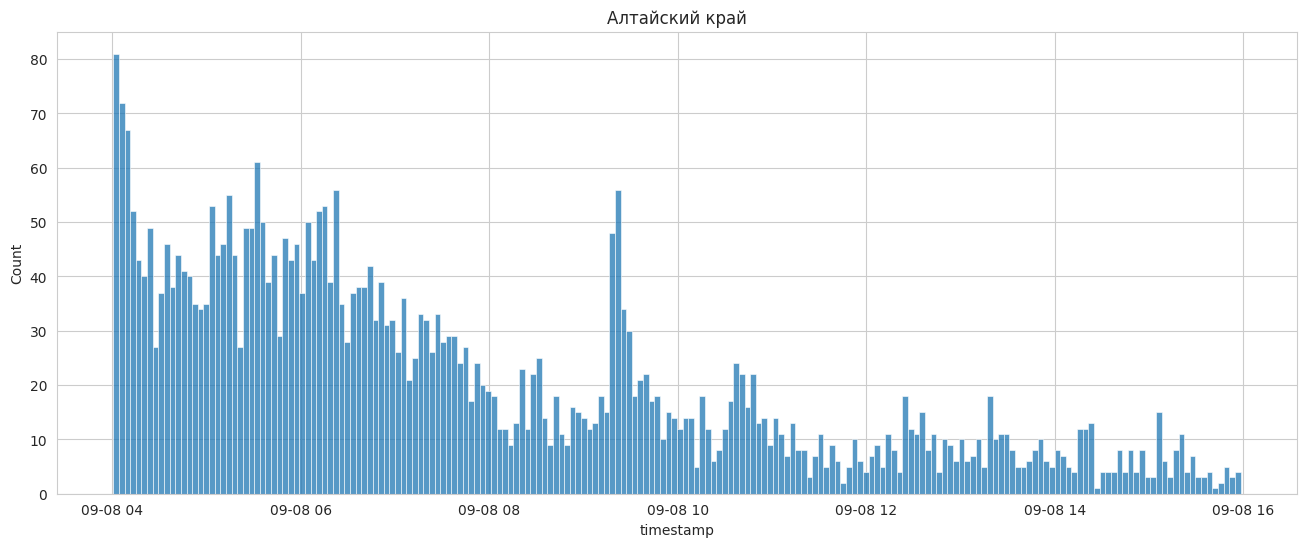

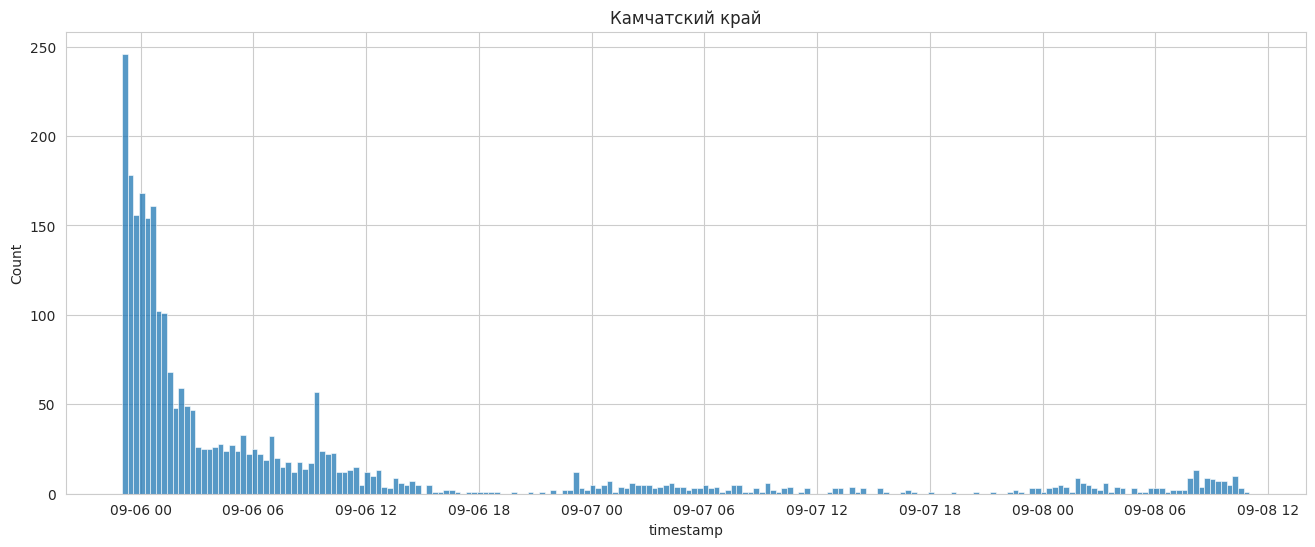

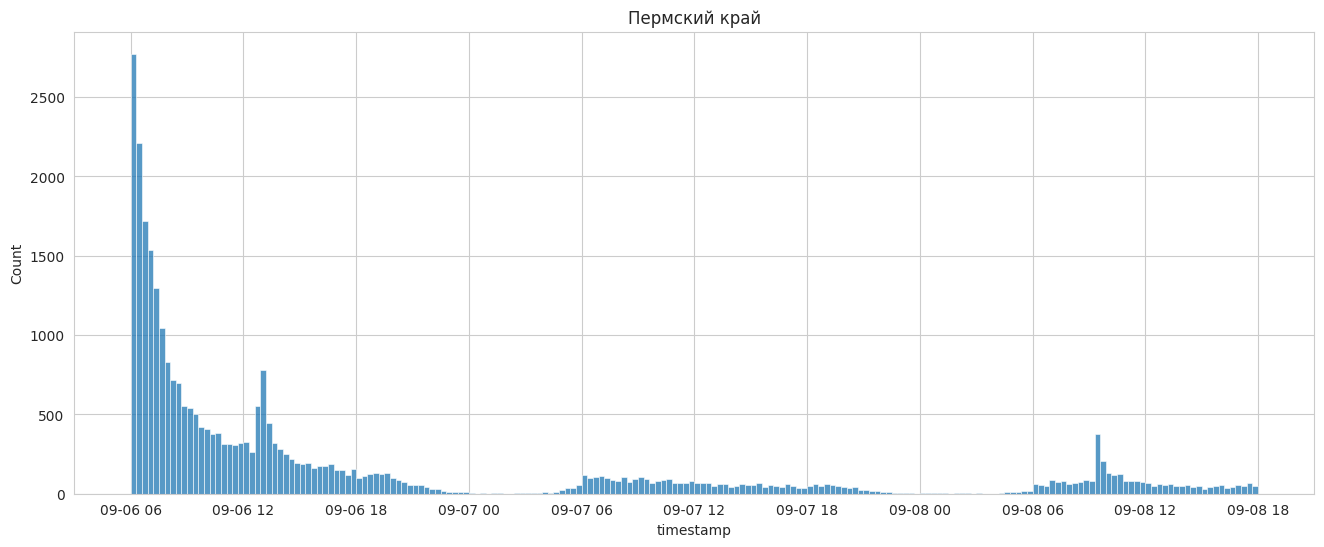

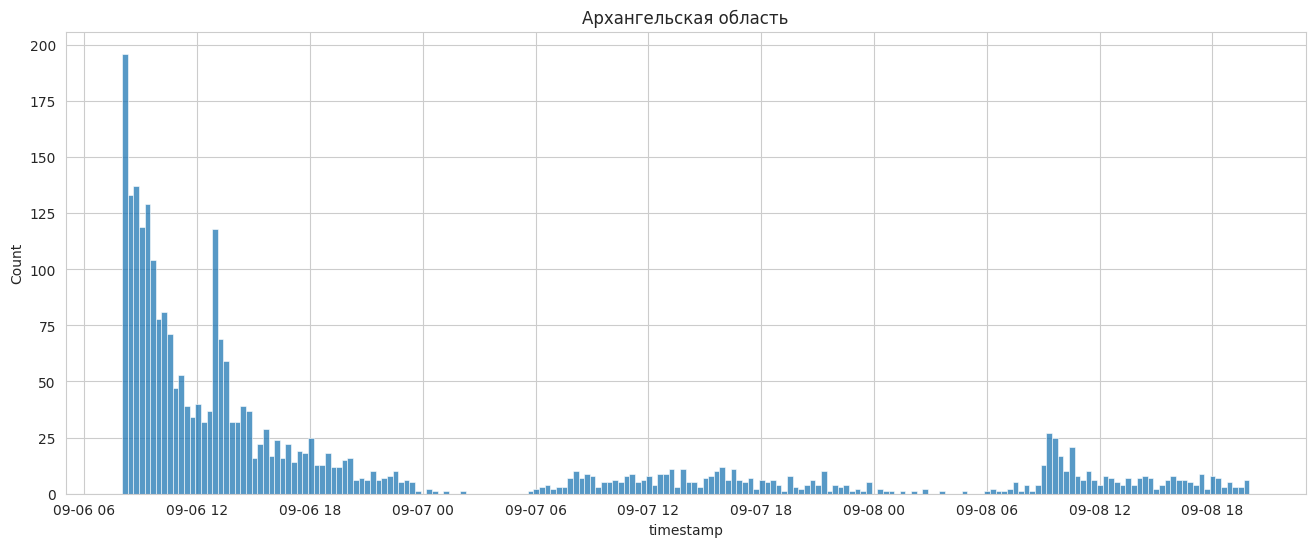

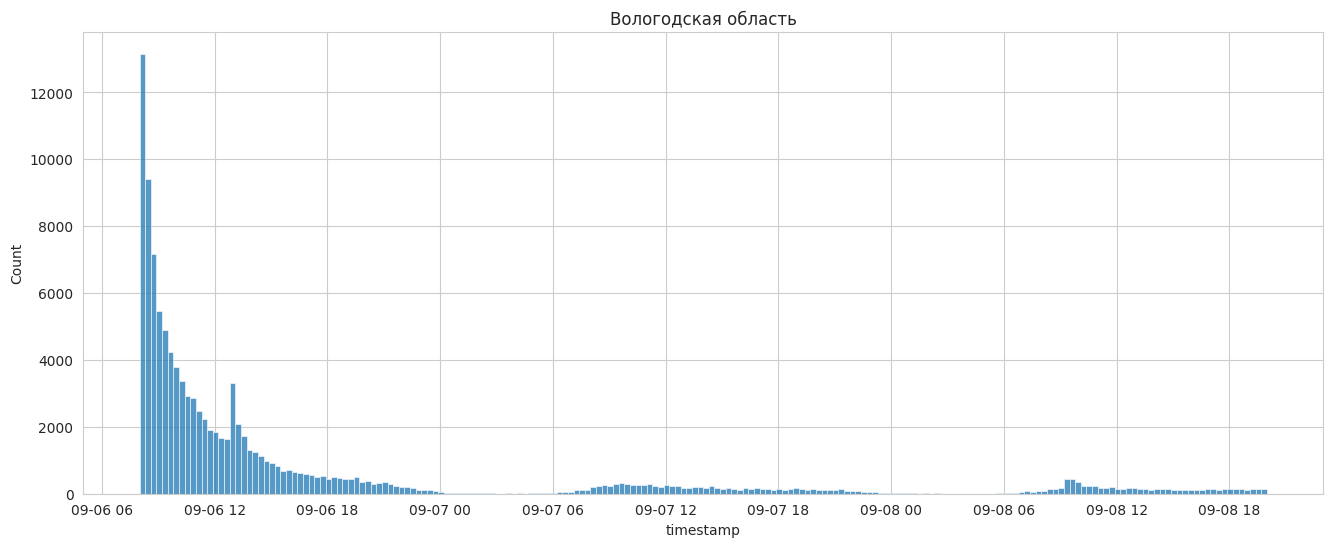

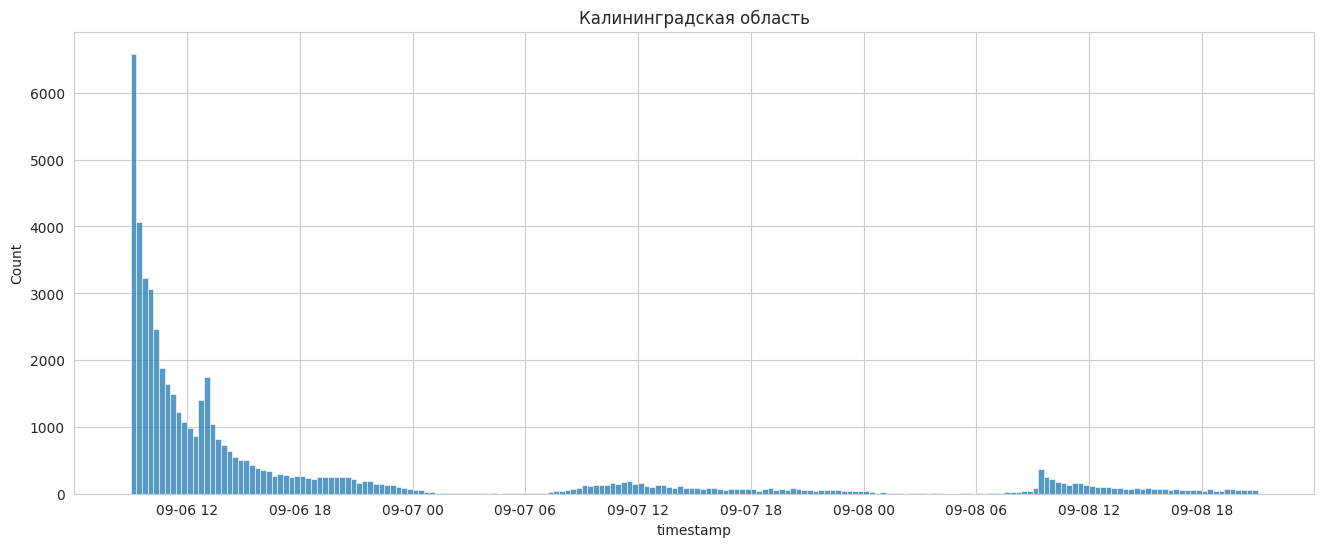

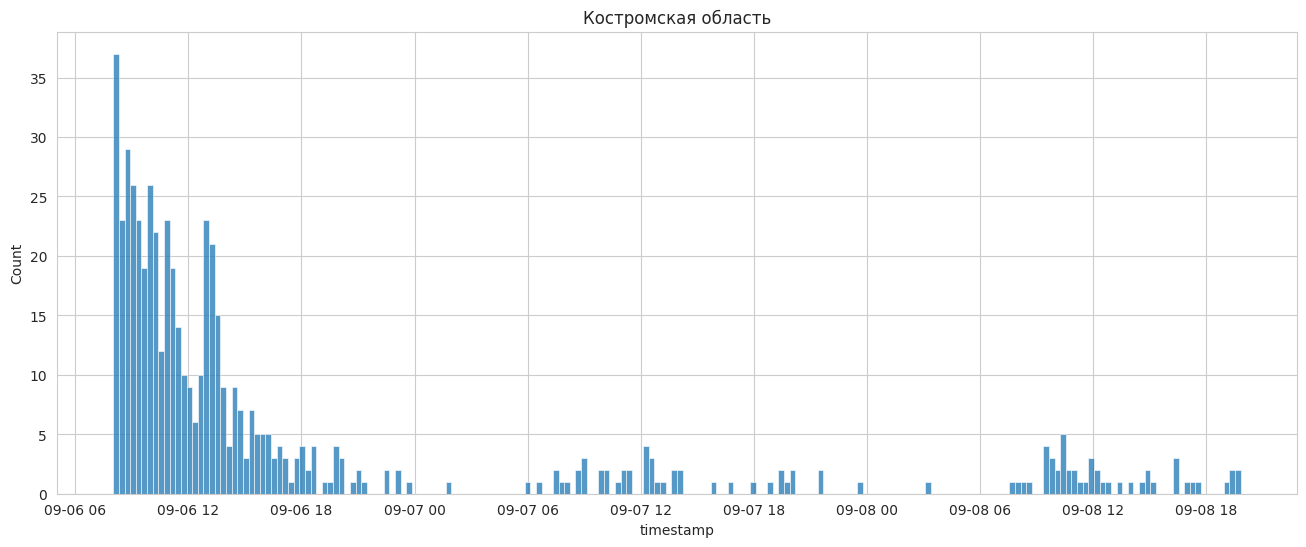

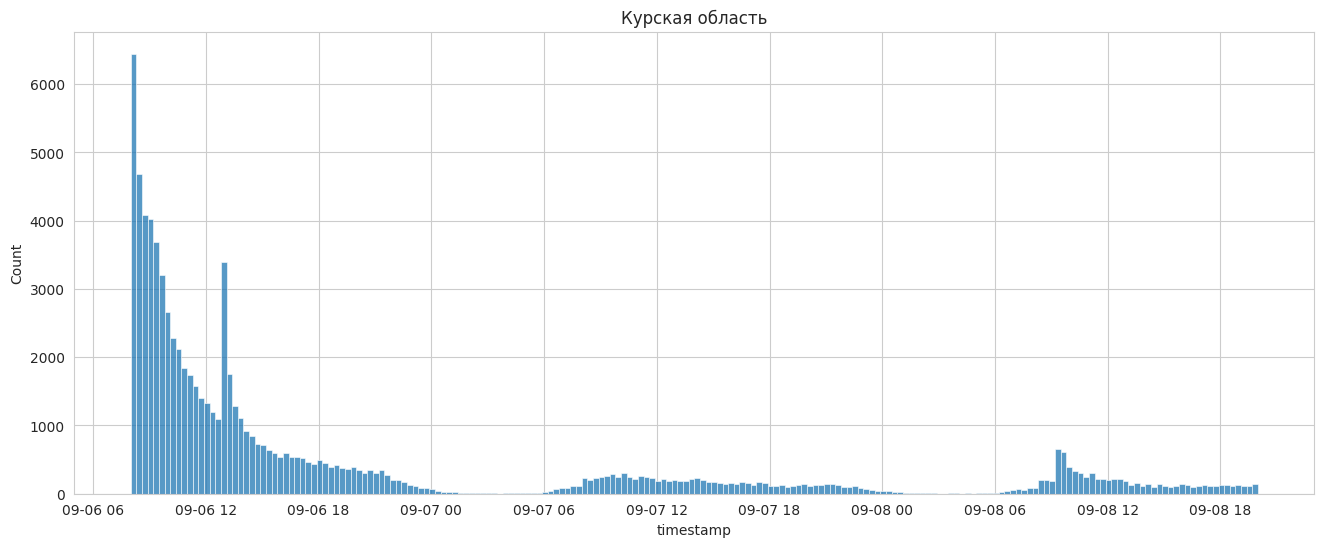

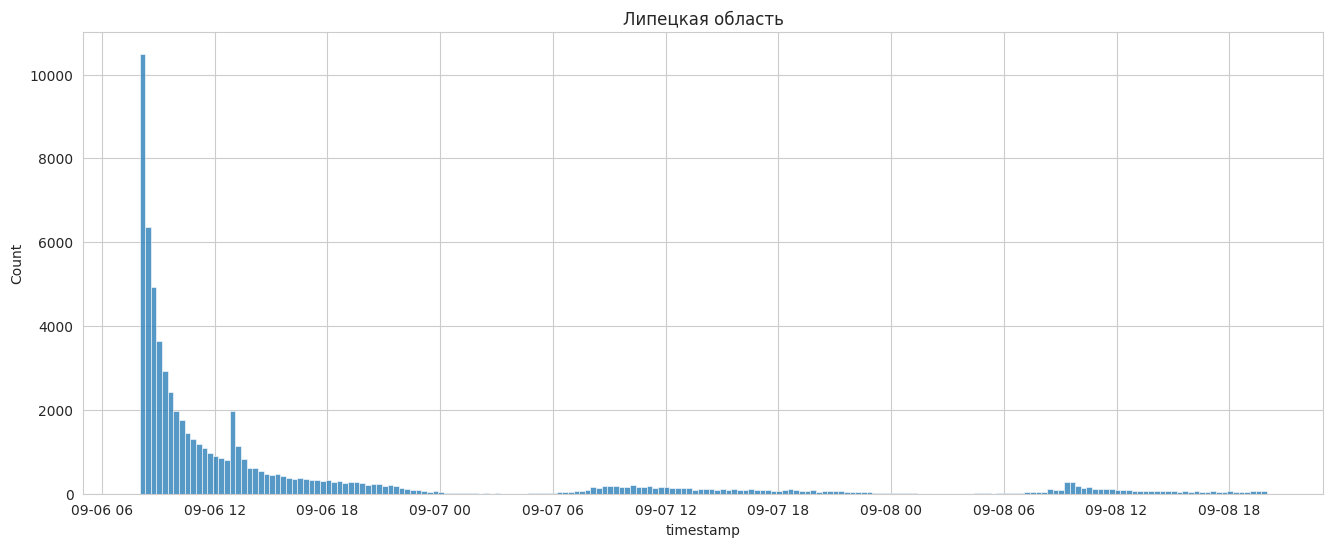

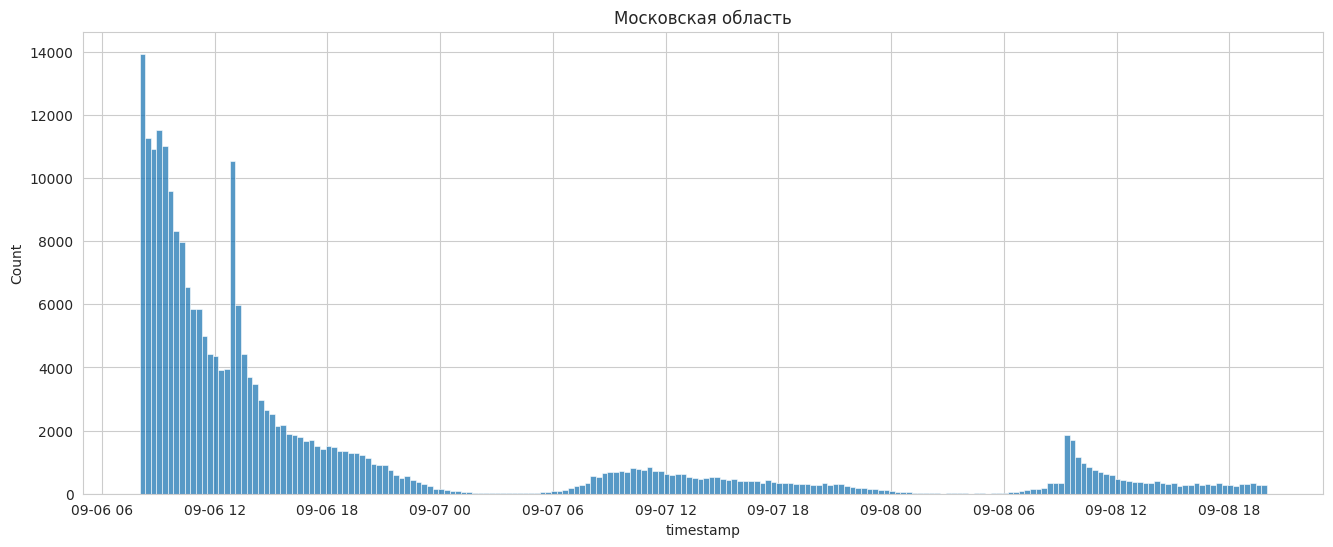

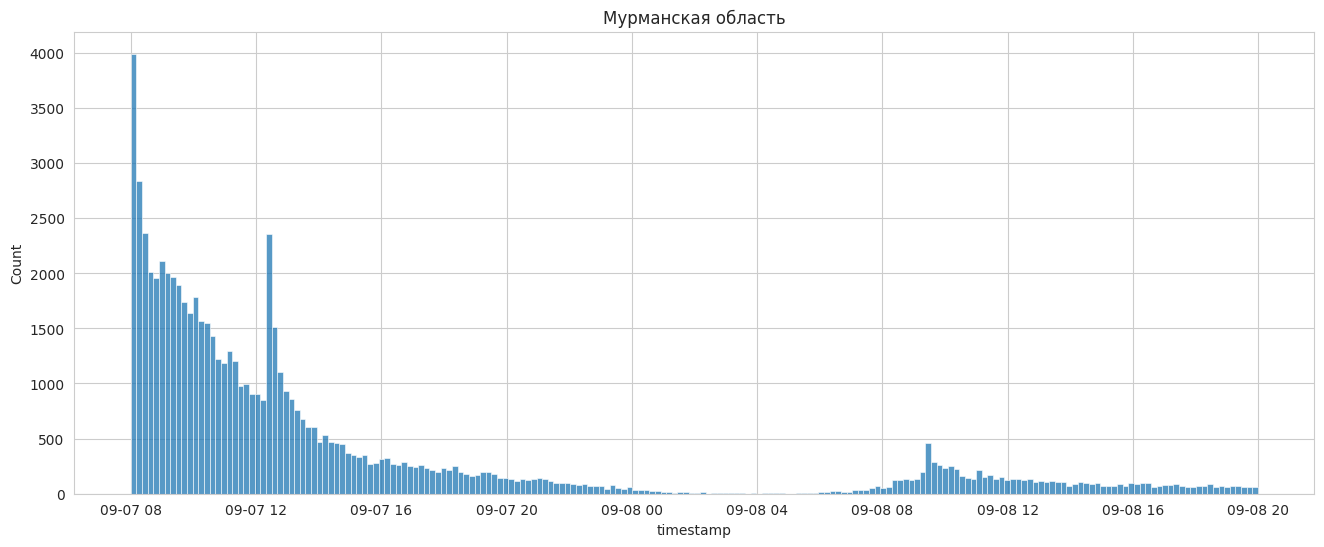

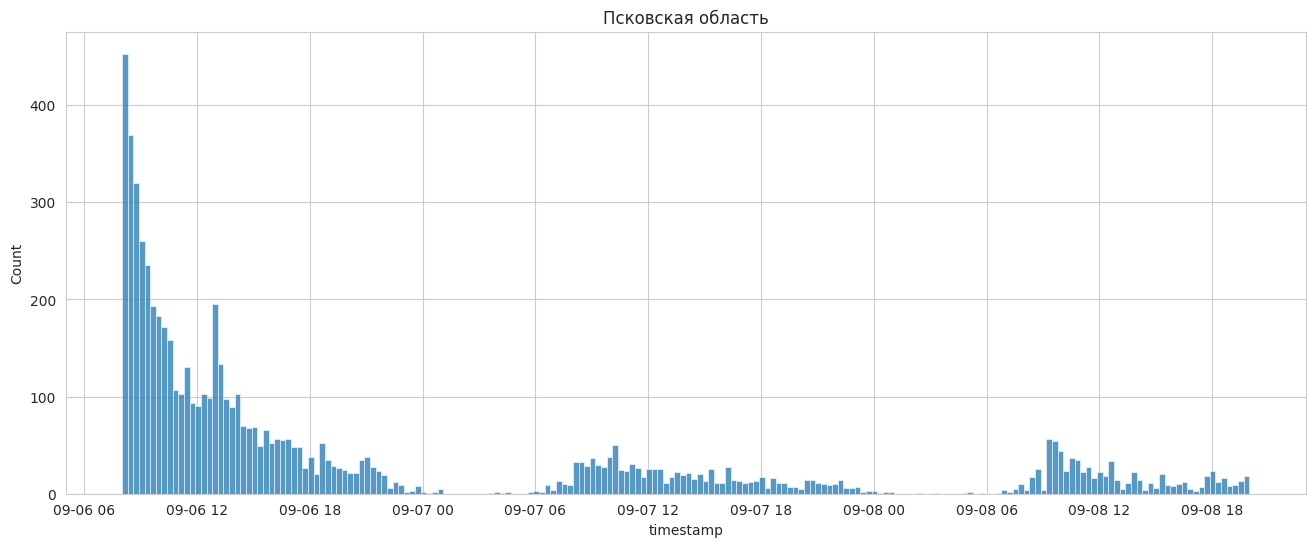

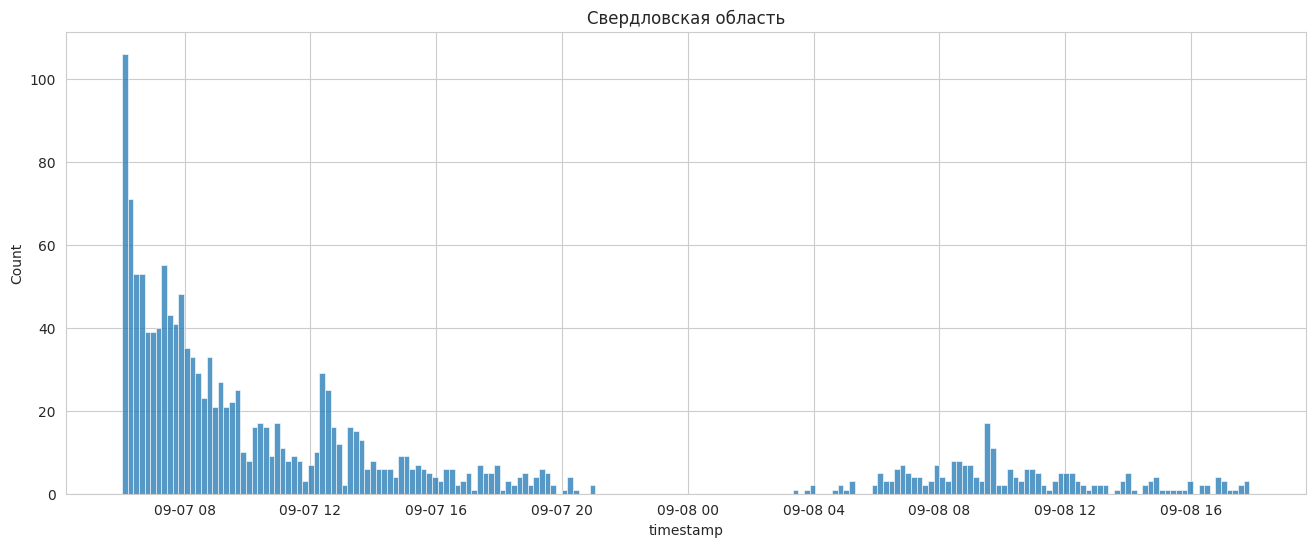

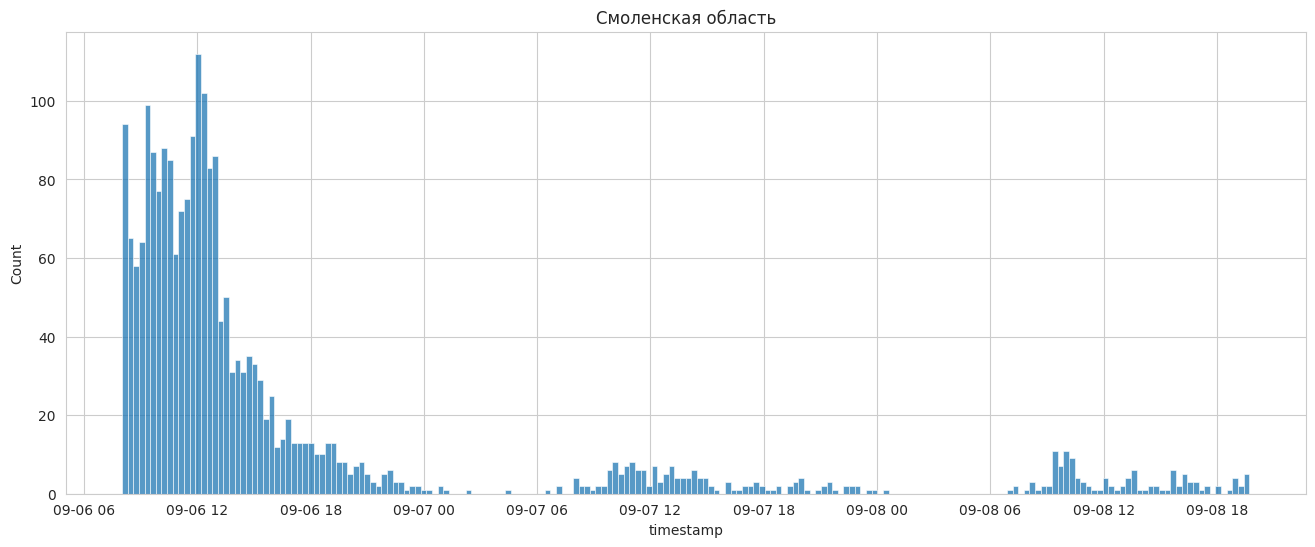

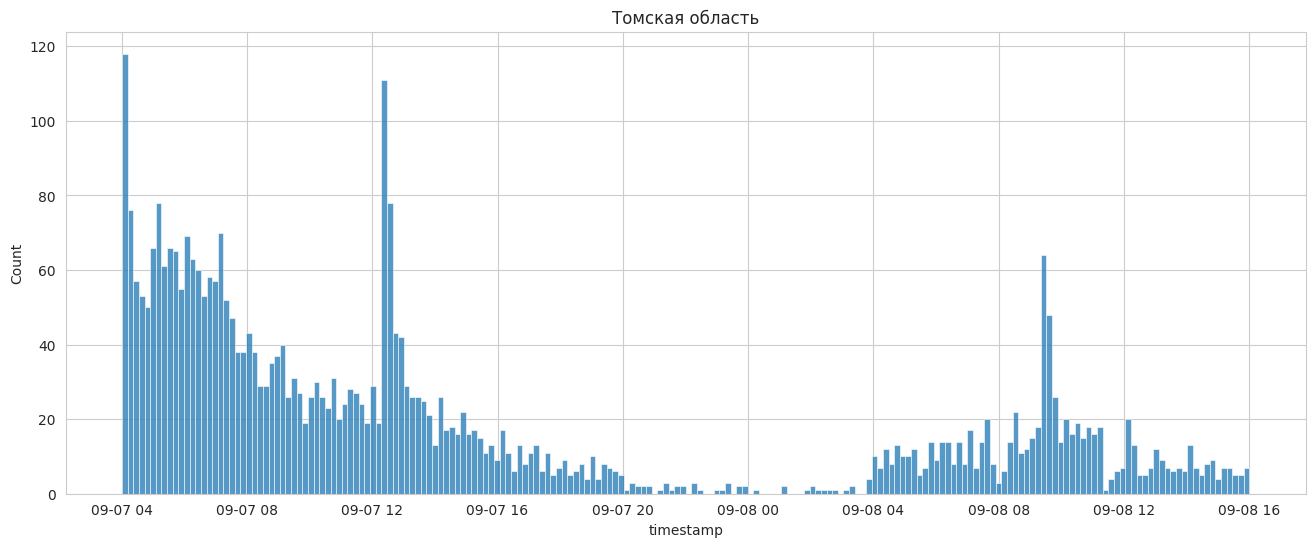

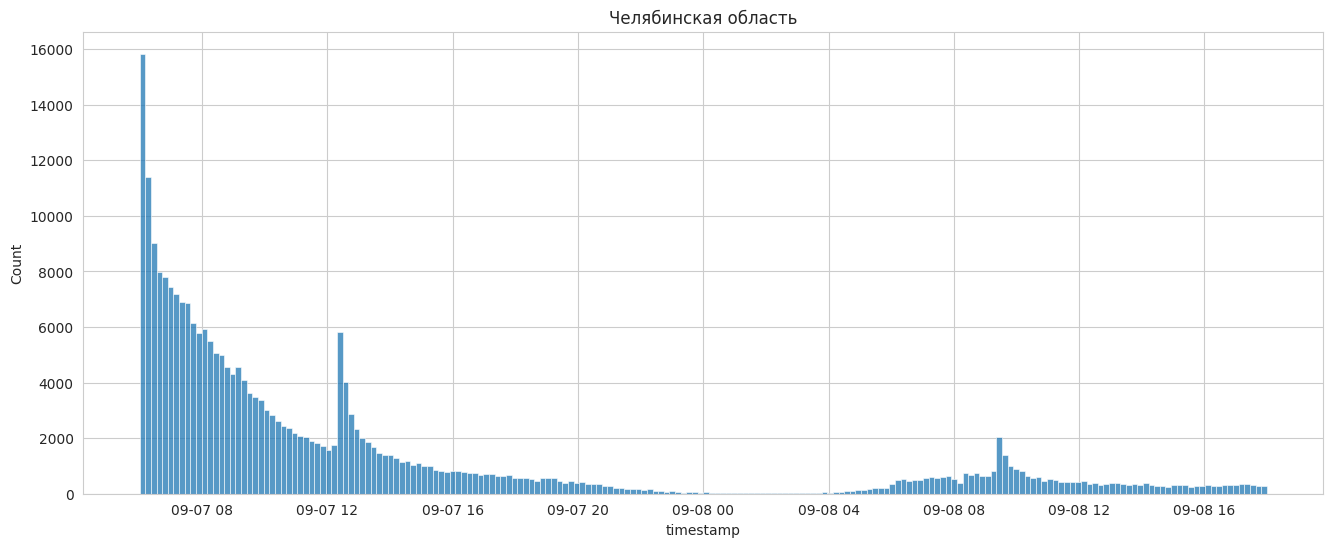

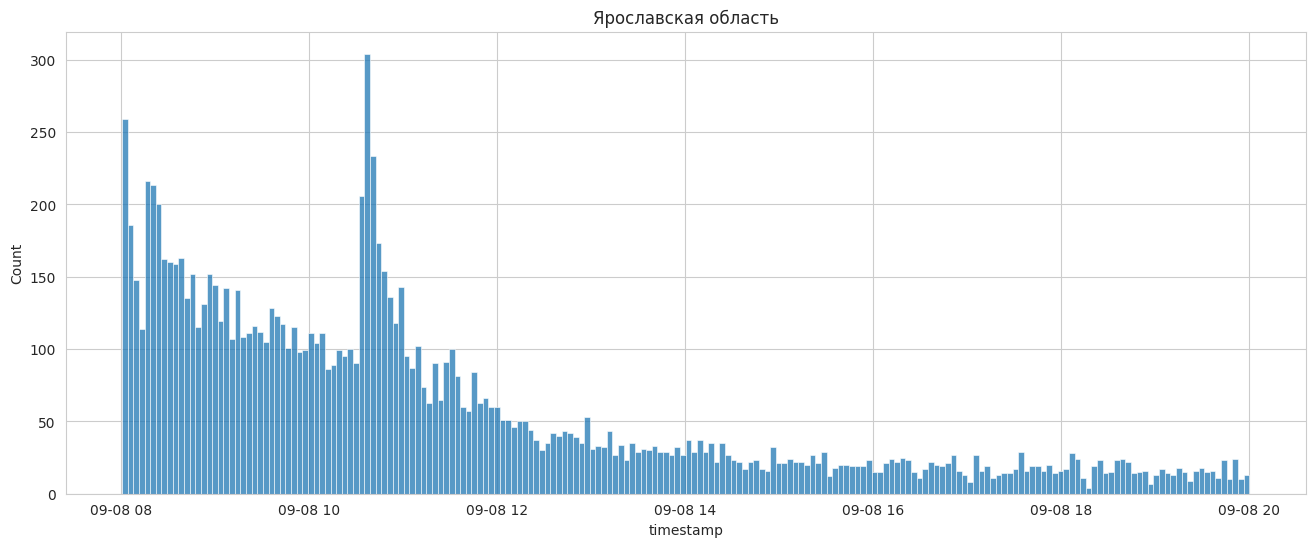

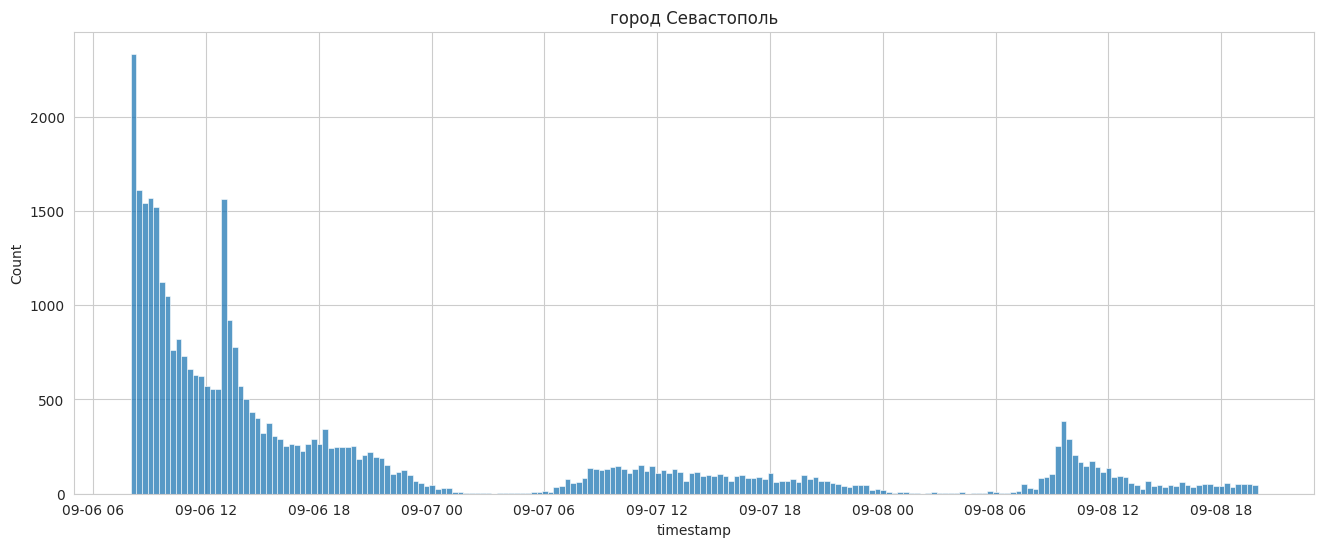

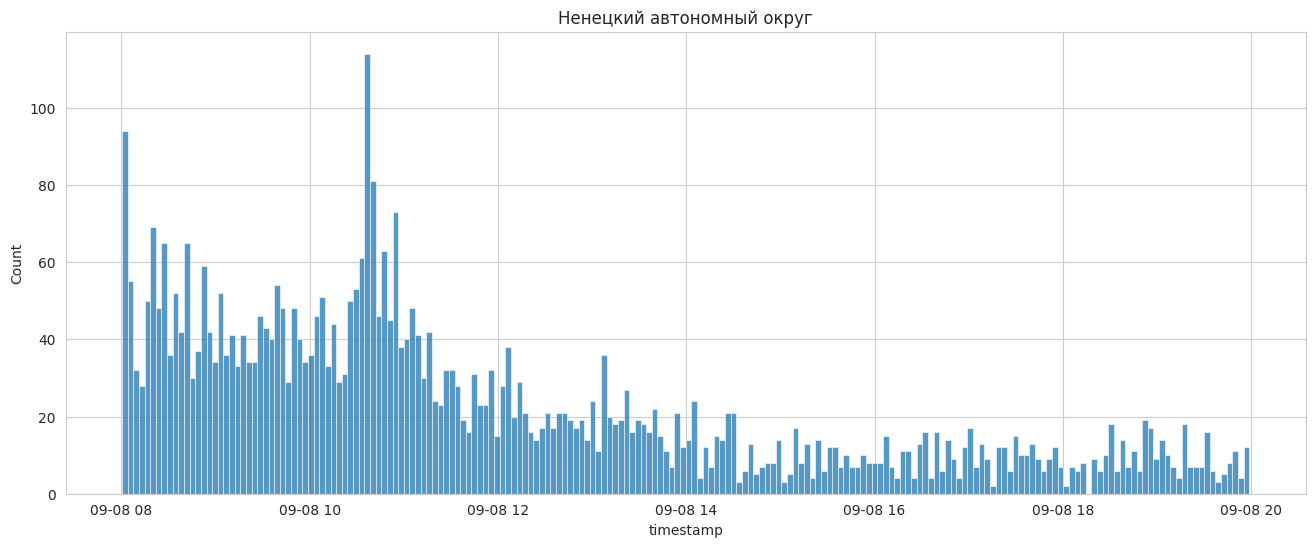

In [52]:
for region in map_regions:
    plt.figure(figsize=(16, 6))

    sns.histplot(df[df.region == region].timestamp, bins=200)
    plt.title(map_regions[region][1])
    plt.show()

## Converting into a DataFrame

In [55]:
data = []

for contract_id, tally in tqdm(results.items()):
    official = []
    candidates = []
    for candidate in load(f'results/voting/{contract_id}')['answers']:
        candidates.append(candidate['name'])
        official.append(candidate['value'])
    assert(official == tally)
    data.append((contract_id, candidates, tally))
    
results_df = pd.DataFrame(data, columns=['contract_id', 'candidates', 'results'])
results_df.to_csv('results.csv', index=False)
results_df

100%|██████████| 2103/2103 [02:51<00:00, 12.28it/s]


,contract_id,candidates,results
0,Bwu2dW9Kf1b5CC8p9LZsSqCZutiTLzg7cAkGz9yL5YMT,"[БОРИСОВ Илья Александрович, СЕДИНА Наталья Ви...","[22, 50, 68, 4]"
1,6rakcm8YPb5UWzJWYoJ4UQHyhKVbM8rBfUYRyv2MvMNF,"[БУСАРГИН Михаил Вячеславович, ДЕРЕНДЯЕВА Лари...","[19, 38, 11, 13, 10]"
2,4xmYaekE4y7VeuTtaSX2WMiRaas8cTwFA6paAJzd8g2g,"[АДУКАНОВА Валентина Петровна, БОБРЫШЕВ Никита...","[58, 45, 24, 13, 10, 13, 18, 40, 47, 49]"
3,J81BdmYocugLtnf1hjeD8hYdVNZMMYErW79458mXfsUx,"[БУТЕНКО Александр Васильевич , ВЕРЕЩАГИНА Нат...","[46, 15, 29, 54]"
4,Cgk4KxFybAVfth7SVmLykNkFf6thEkYdtxkqeL2HPgre,"[ГАФУРОВ Данир Радикович, ДЕВЯТКИН Сергей Генн...","[14, 15, 15, 25, 25, 18, 32, 26, 20, 12, 15, 2..."
...,...,...,...
2098,52GuEx2kpk4p9c2dPF66gDVVKzQbxN9fEWR2NwjkzsSR,"[БЕСПРОЗВАННЫХ Алексей Сергеевич, БУЛАНОВ Макс...","[1108, 98, 172, 100]"
2099,2MmPczFJrkaK9Udszv3s5eugoGMLVMAxhxyMS4AJqL2T,"[БЕСПРОЗВАННЫХ Алексей Сергеевич, БУЛАНОВ Макс...","[666, 59, 123, 70]"
2100,5na6PEzFZRkA2Lbfhgpk49NmnCbYGTxQSw4RNQsMW2jL,"[БЕСПРОЗВАННЫХ Алексей Сергеевич, БУЛАНОВ Макс...","[3491, 225, 579, 276]"
2101,9SeUADgkzq6krKHZEKi1YzFxxP6cCK2ubVLrkamCeVqD,"[БЕСПРОЗВАННЫХ Алексей Сергеевич, БУЛАНОВ Макс...","[7466, 680, 1571, 884]"


In [ ]:
results_df = pd.read_csv('results.csv')
results_df

In [87]:
data = []

for contract_id, (region_code, _, election_name, district_name) in map_contracts.items():
    region_description = map_regions[region_code][1]
    data.append((contract_id, region_description, election_name, district_name))

elections_df = pd.DataFrame(data, columns=['contract_id', 'region', 'election', 'district'])
elections_df.to_csv('elections.csv', index=False)
elections_df

,contract_id,region,election,district
0,ArFx7rnSECKZEHcDBTPRWhyTkLSZzYp8dXTkDyiCaVwu,Республика Алтай,Дополнительные выборы депутатов Совета депута...,Второй
1,3AQEs2DqQT3XntfBkw47UuhqZ5HBns5eVHgbgiJoVSNb,Республика Алтай,Выборы Главы Узнезинского сельского поселения ...,Чемальская районная территориальная избиратель...
2,FcSZd6z5uWhT6pqCQceUCexCVp5cda84foDyDViVFrvp,Республика Алтай,Выборы Главы Паспаульского сельского поселения...,Чойская районная территориальная избирательная...
3,83r3KPCfNcjXjqCpbWWMD1iWSCMryi9DsbnVYoQCEM1i,Республика Алтай,Выборы главы Онгудайского сельского поселения ...,Онгудайская районная территориальная избирател...
4,92WLsT5zPcPezDR4AQPArPvcsZykjdRnVz4xyhDRM4cE,Республика Алтай,Выборы Главы Соузгинского сельского поселения,Майминская районная территориальная избиратель...
...,...,...,...,...
2098,L24P69Kw4bNUKKUycY4BkZuN3nJuNkAGbk9TEdo69wg,Ненецкий автономный округ,"Выборы депутатов Совета городского округа ""Гор...",Городецкий
2099,Htee9Yi3EBtYmnWYb8nML9DaD6ojwEBGrGY14DougiFb,Ненецкий автономный округ,"Выборы депутатов Совета городского округа ""Гор...",Пионерский
2100,3SwcCb3yf6EyDqJyLu6upHHwHKnT5e6E5RdZ3p8pnQsp,Ненецкий автономный округ,"Выборы депутатов Совета городского округа ""Гор...",Северный
2101,6Fga9JtdUdS21fVFfEaM17t64X8Gw18DzUoh1wRhLxgX,Ненецкий автономный округ,"Выборы депутатов Совета городского округа ""Гор...",Южный


In [97]:
data = []
for (contract_id, uik), lists in voter_lists.items():
    initial_voters = 0
    added_voters = 0
    removed_voters = 0
    for optype, count in lists:
        if optype == 'addVotersList':
            initial_voters += count
        elif optype == 'addToVotersList':
            added_voters += count
        elif optype == 'removeFromVotersList':
            removed_voters += count

    data.append((contract_id, uik, initial_voters, added_voters, removed_voters))

uiks_df = pd.DataFrame(data, columns=['contract_id', 'uik', 'initial_voters', 'added_voters', 'removed_voters'])
uiks_df.to_csv('uiks.csv', index=False)
uiks_df

,contract_id,uik,initial_voters,added_voters,removed_voters
0,J81BdmYocugLtnf1hjeD8hYdVNZMMYErW79458mXfsUx,150,101,0,0
1,J81BdmYocugLtnf1hjeD8hYdVNZMMYErW79458mXfsUx,151,2,0,0
2,Cgk4KxFybAVfth7SVmLykNkFf6thEkYdtxkqeL2HPgre,143,91,0,0
3,6rakcm8YPb5UWzJWYoJ4UQHyhKVbM8rBfUYRyv2MvMNF,154,74,0,0
4,4xmYaekE4y7VeuTtaSX2WMiRaas8cTwFA6paAJzd8g2g,145,80,0,0
...,...,...,...,...,...
14643,9SeUADgkzq6krKHZEKi1YzFxxP6cCK2ubVLrkamCeVqD,250,109,0,0
14644,9SeUADgkzq6krKHZEKi1YzFxxP6cCK2ubVLrkamCeVqD,252,270,0,0
14645,9SeUADgkzq6krKHZEKi1YzFxxP6cCK2ubVLrkamCeVqD,251,166,0,0
14646,9SeUADgkzq6krKHZEKi1YzFxxP6cCK2ubVLrkamCeVqD,243,247,0,0


In [98]:
data = []

for contract_id, l in votes.items():
    for ts in l:
        data.append((contract_id, ts))

votes_df = pd.DataFrame(data, columns=['contract_id', 'timestamp'])
votes_df.to_csv('votes.csv', index=False)
votes_df

,contract_id,timestamp
0,6rakcm8YPb5UWzJWYoJ4UQHyhKVbM8rBfUYRyv2MvMNF,2024-09-05 23:01:26
1,6rakcm8YPb5UWzJWYoJ4UQHyhKVbM8rBfUYRyv2MvMNF,2024-09-05 23:03:54
2,6rakcm8YPb5UWzJWYoJ4UQHyhKVbM8rBfUYRyv2MvMNF,2024-09-05 23:06:13
3,6rakcm8YPb5UWzJWYoJ4UQHyhKVbM8rBfUYRyv2MvMNF,2024-09-05 23:07:26
4,6rakcm8YPb5UWzJWYoJ4UQHyhKVbM8rBfUYRyv2MvMNF,2024-09-05 23:09:50
...,...,...
1226051,HyEp8T9JNCXWeUD4emTJoZYVNiQNpYP9GsugCNWj66ZH,2024-09-08 17:37:47
1226052,HyEp8T9JNCXWeUD4emTJoZYVNiQNpYP9GsugCNWj66ZH,2024-09-08 17:52:14
1226053,HyEp8T9JNCXWeUD4emTJoZYVNiQNpYP9GsugCNWj66ZH,2024-09-08 17:57:21
1226054,HyEp8T9JNCXWeUD4emTJoZYVNiQNpYP9GsugCNWj66ZH,2024-09-08 19:12:21


In [99]:
data = []

for contract_id, l in signatures.items():
    for _, uik, ts in l:
        data.append((contract_id, uik, ts))

ballots_df = pd.DataFrame(data, columns=['contract_id', 'uik', 'timestamp'])
ballots_df.to_csv('ballots.csv', index=False)
ballots_df

,contract_id,uik,timestamp
0,J81BdmYocugLtnf1hjeD8hYdVNZMMYErW79458mXfsUx,150,2024-09-05 23:00:38
1,J81BdmYocugLtnf1hjeD8hYdVNZMMYErW79458mXfsUx,150,2024-09-05 23:00:58
2,J81BdmYocugLtnf1hjeD8hYdVNZMMYErW79458mXfsUx,150,2024-09-05 23:01:10
3,J81BdmYocugLtnf1hjeD8hYdVNZMMYErW79458mXfsUx,150,2024-09-05 23:02:25
4,J81BdmYocugLtnf1hjeD8hYdVNZMMYErW79458mXfsUx,150,2024-09-05 23:03:19
...,...,...,...
1234717,EVYEMTKzPiYLXTopnNMBjWh7KK2TR88UzAYLTAYiFmRq,113,2024-09-08 13:53:59
1234718,EVYEMTKzPiYLXTopnNMBjWh7KK2TR88UzAYLTAYiFmRq,112,2024-09-08 14:15:44
1234719,EVYEMTKzPiYLXTopnNMBjWh7KK2TR88UzAYLTAYiFmRq,112,2024-09-08 14:22:48
1234720,EVYEMTKzPiYLXTopnNMBjWh7KK2TR88UzAYLTAYiFmRq,112,2024-09-08 17:25:09


## Investigations

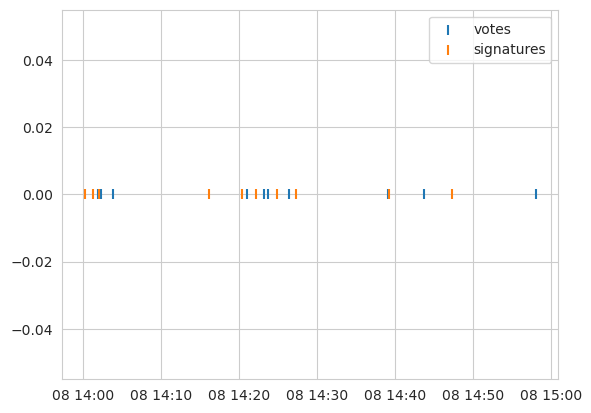

In [137]:
dolgoprudny = '75LLf68JQG5Vokznn9nN9DdVoU1tBokcovXZKcYNppca'


votes = votes_df.query(f'contract_id == "{dolgoprudny}" and "2024-09-08 14:00:00" < timestamp < "2024-09-08 15:00:00"').timestamp
ballots = ballots_df.query(f'contract_id == "{dolgoprudny}" and "2024-09-08 14:00:00" < timestamp < "2024-09-08 15:00:00"').timestamp

plt.scatter(votes, [0] * len(votes), s=50, marker='|', label='votes')
plt.scatter(ballots, [0] * len(ballots), s=50, marker='|', label='signatures')

plt.legend()

plt.show()

In [143]:
votes_df.query(f'contract_id == "{dolgoprudny}" and "2024-09-08 14:00:00" < timestamp < "2024-09-08 15:00:00"')

,contract_id,timestamp
1078033,75LLf68JQG5Vokznn9nN9DdVoU1tBokcovXZKcYNppca,2024-09-08 14:01:54
1078034,75LLf68JQG5Vokznn9nN9DdVoU1tBokcovXZKcYNppca,2024-09-08 14:02:21
1078035,75LLf68JQG5Vokznn9nN9DdVoU1tBokcovXZKcYNppca,2024-09-08 14:03:53
1078036,75LLf68JQG5Vokznn9nN9DdVoU1tBokcovXZKcYNppca,2024-09-08 14:20:59
1078037,75LLf68JQG5Vokznn9nN9DdVoU1tBokcovXZKcYNppca,2024-09-08 14:23:14
1078038,75LLf68JQG5Vokznn9nN9DdVoU1tBokcovXZKcYNppca,2024-09-08 14:23:41
1078039,75LLf68JQG5Vokznn9nN9DdVoU1tBokcovXZKcYNppca,2024-09-08 14:26:26
1078040,75LLf68JQG5Vokznn9nN9DdVoU1tBokcovXZKcYNppca,2024-09-08 14:39:04
1078041,75LLf68JQG5Vokznn9nN9DdVoU1tBokcovXZKcYNppca,2024-09-08 14:43:46
1078042,75LLf68JQG5Vokznn9nN9DdVoU1tBokcovXZKcYNppca,2024-09-08 14:58:05


In [142]:
ballots_df.query(f'contract_id == "{dolgoprudny}" and "2024-09-08 14:00:00" < timestamp < "2024-09-08 15:00:00"')

,contract_id,uik,timestamp
1060263,75LLf68JQG5Vokznn9nN9DdVoU1tBokcovXZKcYNppca,347,2024-09-08 14:00:14
1060264,75LLf68JQG5Vokznn9nN9DdVoU1tBokcovXZKcYNppca,347,2024-09-08 14:01:17
1060265,75LLf68JQG5Vokznn9nN9DdVoU1tBokcovXZKcYNppca,345,2024-09-08 14:02:04
1060266,75LLf68JQG5Vokznn9nN9DdVoU1tBokcovXZKcYNppca,346,2024-09-08 14:16:13
1060267,75LLf68JQG5Vokznn9nN9DdVoU1tBokcovXZKcYNppca,346,2024-09-08 14:20:23
1060268,75LLf68JQG5Vokznn9nN9DdVoU1tBokcovXZKcYNppca,342,2024-09-08 14:22:12
1060269,75LLf68JQG5Vokznn9nN9DdVoU1tBokcovXZKcYNppca,346,2024-09-08 14:24:55
1060270,75LLf68JQG5Vokznn9nN9DdVoU1tBokcovXZKcYNppca,346,2024-09-08 14:27:21
1060271,75LLf68JQG5Vokznn9nN9DdVoU1tBokcovXZKcYNppca,346,2024-09-08 14:39:13
1060272,75LLf68JQG5Vokznn9nN9DdVoU1tBokcovXZKcYNppca,341,2024-09-08 14:47:19


In [100]:
turnout = ballots_df.groupby(['contract_id']).size()
turnout = turnout.reset_index()
turnout.columns = ['contract_id', 'ballots']
turnout

,contract_id,ballots
0,121WUnLPiNKtBjQZpkRt2HrNbA4q65QzRKJ1mvxxAXmD,549
1,12XyLZ5SP2HH2mmdMRRtu7JU9qWXG6EFsQusSccTB3fT,775
2,12YspJsekjLNH3Ldb3jM9ch9XBY7GP8TQScEsQ5XUb2u,132
3,14N4xYMRTGvVrZisz2oMW9aZAXE65E2uGbTWq4M29zEg,429
4,14XfyD6wAtFW1UDYC7g4rLxi6ACCPa5zcg9GeZVHJRJJ,25
...,...,...
2090,vsqHZ7Buc8Tm7e65yNV1bEY6KaJstLG2UPvbUq9qSGH,85
2091,xUbuj7dk8EyoXpfdDrNN7JHXcabdttcHCE7nZnBedRa,14
2092,yD3uFyXAMPD2FVf46EnDdM2SR5VfxodoBVJEStSnv45,3220
2093,zMuz5SZWj7o96tVEooFxHxauQGeeUhsSJ4fpUpYMeNC,81


In [101]:
total = uiks_df.groupby('contract_id').sum(numeric_only=True).drop('uik', axis=1)
total = total.merge(elections_df, on='contract_id')
total

,contract_id,initial_voters,added_voters,removed_voters,region,election,district
0,121WUnLPiNKtBjQZpkRt2HrNbA4q65QzRKJ1mvxxAXmD,624,0,0,Московская область,Выборы депутатов Совета депутатов Сергиево-Пос...,Сергиево-Посадский
1,12XyLZ5SP2HH2mmdMRRtu7JU9qWXG6EFsQusSccTB3fT,828,0,0,Вологодская область,Выборы Губернатора Вологодской области,территориальная избирательная комиссия Чагодощ...
2,12YspJsekjLNH3Ldb3jM9ch9XBY7GP8TQScEsQ5XUb2u,141,0,0,Республика Марий Эл,Выборы депутатов Собрания депутатов Большепара...,Большепаратский одиннадцатимандатный
3,14N4xYMRTGvVrZisz2oMW9aZAXE65E2uGbTWq4M29zEg,484,0,0,Челябинская область,Выборы Губернатора Челябинской области,Территориальная избирательная комиссия города ...
4,14XfyD6wAtFW1UDYC7g4rLxi6ACCPa5zcg9GeZVHJRJJ,28,0,0,Липецкая область,Выборы депутатов Совета депутатов сельского по...,Первый
...,...,...,...,...,...,...,...
2098,vsqHZ7Buc8Tm7e65yNV1bEY6KaJstLG2UPvbUq9qSGH,110,0,0,Архангельская область,Дополнительные выборы депутатов Собрания депут...,Округ №15
2099,xUbuj7dk8EyoXpfdDrNN7JHXcabdttcHCE7nZnBedRa,20,0,0,Камчатский край,Выборы депутатов Собрания депутатов Тигильског...,Второй
2100,yD3uFyXAMPD2FVf46EnDdM2SR5VfxodoBVJEStSnv45,3529,0,0,Московская область,Выборы депутатов Совета депутатов городского о...,Первый
2101,zMuz5SZWj7o96tVEooFxHxauQGeeUhsSJ4fpUpYMeNC,88,0,0,Челябинская область,Выборы депутатов Совета депутатов Кременкульск...,Второй


In [102]:
df = total.merge(turnout, on='contract_id')
df['turnout'] = df.ballots / df.initial_voters
df.query('election == "Выборы депутатов Республики Алтай"').sort_values('district')

,contract_id,initial_voters,added_voters,removed_voters,region,election,district,ballots,turnout
19,28BRyp5nTcHHs5gsrd5YqYuG9NCFwoSPsrKdSC3SPiRg,954,0,0,Республика Алтай,Выборы депутатов Республики Алтай,Округ №1,904,0.947589
570,6KVHVamsLz53rvsq7KcrsVtYPZRjiVUNzop9tSRSRUAf,954,0,0,Республика Алтай,Выборы депутатов Республики Алтай,Округ №1,904,0.947589
276,4EcF6KoTx84fY1pXaGWaiePTpD7Lj7soJks7yXZwkpr2,1123,0,0,Республика Алтай,Выборы депутатов Республики Алтай,Округ №10,1050,0.934996
747,7gik6NoSUgTe5J1YYjBA1xxFDuuMXqTxp3AYQqEGBiHs,1123,0,0,Республика Алтай,Выборы депутатов Республики Алтай,Округ №10,1050,0.934996
83,2brRV8YqdGJNTuyGV2NoB2CqqK8oYXrg2gknXP6eG2KB,586,0,0,Республика Алтай,Выборы депутатов Республики Алтай,Округ №11,545,0.930034
933,96wHBGi5T2m473fKwub542wFhEfpbWb4bytrXJvSEcJg,586,0,0,Республика Алтай,Выборы депутатов Республики Алтай,Округ №11,545,0.930034
1815,GdAKMSyDdTgPEw4P6i8LycvkHjuYwNz9h4CRmttUsMi7,999,0,0,Республика Алтай,Выборы депутатов Республики Алтай,Округ №12,937,0.937938
1068,AD715kuBThyvUp9vVWReQknqYrU1n9gryMnfsRqeM8ED,999,0,0,Республика Алтай,Выборы депутатов Республики Алтай,Округ №12,937,0.937938
1725,FsVyKTBkyfvgfA7tsGzhM7ToboYrLsWhgihsHwK5ahde,674,0,0,Республика Алтай,Выборы депутатов Республики Алтай,Округ №13,637,0.945104
1651,FDo5ChpEivtiEEgbNvmacMe5HgeYuMdNtxKVu7THSZKL,674,0,0,Республика Алтай,Выборы депутатов Республики Алтай,Округ №13,637,0.945104
